## Analysis of high- and low-variance PCs in velocity space during rotation (panel B)

In [1]:
from definitions import ROOT_DIR
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from functions_notebook import make_parallel_envs,set_config,cross_project_kin,plot_cross_projection,mean_ratio
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib import RecurrentPPO
from envs.environment_factory import EnvironmentFactory

/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


### A. Low-variance PCs : linear classification performance

1. __Go to 2. to directly load the previously-obtained data__\
a. Define the 3 tasks : hold, cw, ccw\
b. Generate and label the velocities for each task\
c. Save the data

In [4]:
num_ep = 50
num_cond = 3

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

C_hold = set_config(period=1e100,rot_dir=None)
C_cw = set_config(period=5,rot_dir="cw")
C_ccw = set_config(period=5,rot_dir="ccw")

configs = {'hold':C_hold,'cw':C_cw,'ccw':C_ccw}

conds = []

for task in configs :
    envs = make_parallel_envs(env_name, configs[task], num_env=1)
    envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
    envs.training = False
    envs.norm_reward = False
    custom_objects = {
        "learning_rate": lambda _: 0,
        "lr_schedule": lambda _: 0,
        "clip_range": lambda _: 0,
    }
    model = RecurrentPPO.load(
            PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
        )

    eval_model = model
    eval_env = EnvironmentFactory.create(env_name,**configs[task])
    tot_vel = []
    for n in range(num_ep):
        obs_tot = []
        cum_reward = 0
        lstm_states = None
        obs = eval_env.reset()
        episode_starts = np.ones((1,), dtype=bool)
        done = False
        timestep = 0
        while not done: 
            if render :
                eval_env.sim.render(mode="window")
                
            timestep += 1
            action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                    state=lstm_states,
                                                    episode_start=episode_starts,
                                                    deterministic=True,
                                                    )
                                                        
            obs, rewards, done, info = eval_env.step(action)
            episode_starts = done
            cum_reward += rewards
            obs_tot.append(obs)
        if len(obs_tot) < 200 :
            print("Stopped before 200, task : %s" %task, " number of steps : ",timestep)
            temp = np.zeros((200,86))
            temp[:len(obs_tot)] += obs_tot
            obs_tot = temp
        print('episode %s : '%n,cum_reward)

        # MEASURE JOINT POSITION AND VELOCITY
        hand_positions = np.array(obs_tot)[:,0:23]    
        hand_velocities = np.array([np.diff(pos)/0.0025 for pos in hand_positions.T]).T
        hand_velocities = np.vstack((np.zeros((1,23)),hand_velocities))                                

        conds.append({'task':configs[task],'encoding':task,'reward':cum_reward,'hand velocity':np.array(hand_velocities)})

'''fp = ""
fp_conditions = open(fp, 'wb')
pickle.dump(conds,fp_conditions)
fp_conditions.close()'''

MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Task.BAODING_CCW
episode 0 :  980.0
Task.BAODING_CCW
episode 1 :  1000.0
Task.BAODING_CCW
episode 2 :  1000.0
Task.BAODING_CCW
episode 3 :  855.0
Task.BAODING_CCW
episode 4 :  940.0
Task.BAODING_CCW
episode 5 :  930.0
Task.BAODING_CCW
episode 6 :  945.0
Task.BAODING_CCW
episode 7 :  955.0
Task.BAODING_CCW
episode 8 :  985.0
Task.BAODING_CCW
episode 9 :  980.0
Task.BAODING_CCW
episode 10 :  605.0
Task.BAODING_CCW
episode 11 :  980.0
Task.BAODING_CCW
episode 12 :  975.0
Task.BAODING_CCW
episode 13 :  765.0
Task.BAODING_CCW
episode 14 :  990.0
Task.BAODING_CCW
episode 15 :  955.0
Task.BAODING_CCW
episode 16 :  995.0
Task.BAODING_CCW
episode 17 :  840.0
Task.BAODING_CCW
episode 18 :  695.0
Task.BAODING_CCW
episode 19 :  945.0
Task.BAODING_CCW
episode 20 :  990.0
Task.BAODING_CCW
episode 21 :  810.0
Task.BAODING_CCW
episode 22 :  10.0
Task.BAODING_CCW
episode 23 :  960.0
Task.BAODING_CCW
episode 24 :  955.0
Task.BAODING_CCW
episode 25 :  960.0
Task.BAODING_CCW
episode 26 :  85.0
Task.BAODIN

KeyboardInterrupt: 

2. Load the velocities and labels for each task

In [8]:
# Load the file from Basecamp : 'synergies_tasks'
conds = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/synergies_tasks','rb'))
hand_kinematics = np.concatenate([cond['hand velocity'] for cond in conds])

3. __Go to 4. to directly load the classification performance vs. number of high-variance PCs removed__\
a. Compute the PCs\
b. Project the velocities on a progressively lower-dimensional subspace\
c. Train a linear classifier to identify the task's identity (Leave-One-Out cross-validation)\
d. Save the data

In [9]:
n_comp = 23
pca = PCA(n_components=n_comp).fit(hand_kinematics)

num_ep = 50
num_cond = 3
performance = []
for k in range(n_comp):
    print(k)
    components = pca.components_[k:]
    projected_conds = [{'label':cond['encoding'], 'projected velocity':np.dot(cond['hand velocity']-pca.mean_,components.T)} for cond in conds]
    X = [d['projected velocity'].flatten() for d in projected_conds]
    y = [d['label'] for d in projected_conds]
    class_performance = []
    for i in range(num_ep):
        x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=num_cond*(num_ep-1),test_size=num_cond)
        lda = LDA().fit(x_train,y_train)
        class_performance.append(lda.score(X=x_test,y=y_test))

    performance.append(np.mean(np.array(class_performance)))
 
'''fp = ""    
fp_perf = open(fp, 'wb')
pickle.dump(performance,fp_perf)
fp.close()'''

0
1
2


KeyboardInterrupt: 

4. Load the classification performance vs. number of high-variance PCs removed

In [11]:
# Load the file from basecamp : 'class_performance_tasks_r'
performance = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/class_performance_tasks_r','rb'))
n_comp=23

5. Plot the classification performance vs. number of high-variance PCs removed

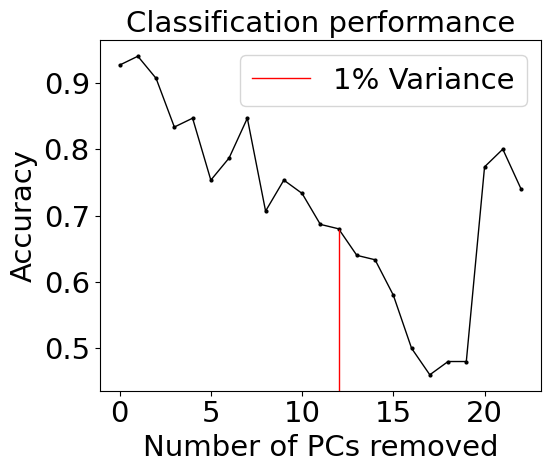

In [12]:
pc_low_variance = next(x[0] for x in enumerate(pca.explained_variance_ratio_) if x[1] < 0.01)
plt.plot([n for n in range(n_comp)],performance,'-o',linewidth=1,markersize=2,color='black')
plt.axvline(x=pc_low_variance, ymax=0.46,color='r', linestyle='-',linewidth=1,label='1% Variance')
plt.legend(fontsize=21)
plt.xlabel('Number of PCs removed',fontsize=21)
plt.ylabel('Accuracy',fontsize=21)
plt.title('Classification performance',fontsize=21)
plt.yticks(fontsize=21)
plt.xticks(fontsize=21)
plt.subplots_adjust(left=0.21,bottom=0.15)

### B. High-variance PCs : cross-projection similarity

1. Load the velocities and labels for each task (same as in section A.2.a)

In [2]:
# Load the file from basecamp : 'synergies_tasks'
conds = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/synergies_tasks','rb')) 

hold_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='hold'])
cw_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='cw'])
ccw_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='ccw'])

n_comp = 23
n_highpc = 12 # Considering that the first 12 PCs account for most of the variance = high-variance PCs

2. a. Cross-projection \
b. Quantify the degree of similarity between subpaces by computing average V2/V1\
c. Visualize the degree of similarity between subspaces by plotting cumulative explained variances

{'hold vs. cw': 1.0001601, 'hold vs. ccw': 1.0001601, 'cw vs. ccw': 0.9998994}


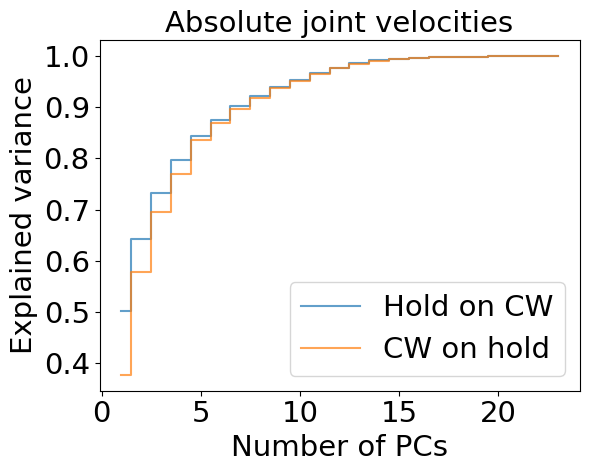

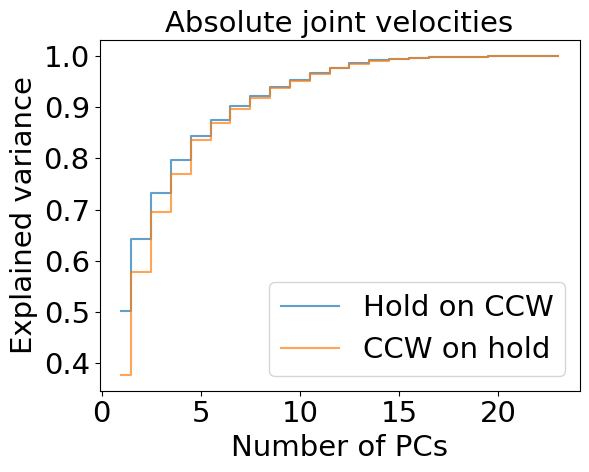

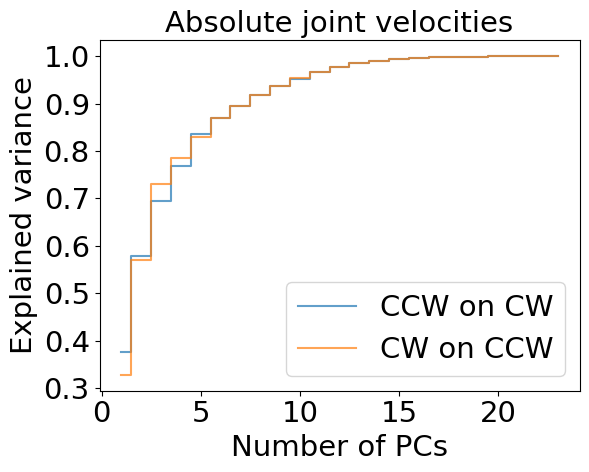

In [3]:
# Cross-projection
cproj_hold_cw = cross_project_kin(vel1=hold_velocities,vel2=ccw_velocities,n_comp=n_comp,n_highpc=n_highpc)
cproj_hold_ccw = cross_project_kin(vel1=hold_velocities,vel2=ccw_velocities,n_comp=n_comp,n_highpc=n_highpc)
cproj_ccw_cw = cross_project_kin(vel1=ccw_velocities,vel2=cw_velocities,n_comp=n_comp,n_highpc=n_highpc)

# Quantify
hold_cw = mean_ratio(n_highpc=n_highpc,cproj=cproj_hold_cw)
hold_ccw = mean_ratio(n_highpc=n_highpc,cproj=cproj_hold_ccw)
ccw_cw = mean_ratio(n_highpc=n_highpc,cproj=cproj_ccw_cw)

hold_cw_r = hold_cw[0]
hold_ccw_r = hold_ccw[0]
ccw_cw_r = ccw_cw[0]

V = {'hold vs. cw':np.round(hold_cw_r,7), 'hold vs. ccw':np.round(hold_ccw_r,7), 'cw vs. ccw':np.round(ccw_cw_r,7)}
print(V)

# Visualize
plot_cross_projection(n_comp=n_comp,cum_1_2=hold_cw[1],cum_2_1=hold_cw[2],label1='Hold on CW',label2='CW on hold')
plot_cross_projection(n_comp=n_comp,cum_1_2=hold_ccw[1],cum_2_1=hold_ccw[2],label1='Hold on CCW',label2='CCW on hold')
plot_cross_projection(n_comp=n_comp,cum_1_2=ccw_cw[1],cum_2_1=ccw_cw[2],label1='CCW on CW',label2='CW on CCW')
